In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from keras.preprocessing.image import load_img
import os

In [3]:
!wget https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip

--2025-12-24 06:36:25--  https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.222.206.35, 2600:1406:bc00:e8a::317f, 2600:1406:bc00:e85::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.222.206.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M  79.3MB/s    in 7.4s    

2025-12-24 06:36:33 (106 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [63]:
#!unzip kagglecatsanddogs_5340.zip

(Dog - 1, Cat = 0)

In [ ]:
## create DataFrame for input and output

In [5]:
input_path = []
label = []
for class_name in os.listdir('PetImages'):
  for path in os.listdir('PetImages/'+class_name):
    if class_name == 'Cat':
      label.append(0)
    else:
      label.append(1)
    input_path.append(os.path.join('PetImages',class_name,path))
print(input_path[0],label[0])

PetImages/Cat/308.jpg 0


In [6]:
print(input_path[10],label[10])

PetImages/Cat/132.jpg 0


In [7]:
len(label)

25002

In [25]:
df['label'] = df['label'].astype('string')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25002 entries, 0 to 25001
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  25002 non-null  object
 1   label   25002 non-null  string
dtypes: object(1), string(1)
memory usage: 390.8+ KB


In [19]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,images,label
0,PetImages/Cat/12054.jpg,0
1,PetImages/Cat/12424.jpg,0
2,PetImages/Cat/3198.jpg,0
3,PetImages/Dog/1478.jpg,1
4,PetImages/Cat/7359.jpg,0


In [43]:
#delete db files
for i in df['images']:
  if '.jpg' not in i:
    print(i)

PetImages/Cat/Thumbs.db
PetImages/Dog/Thumbs.db


In [46]:
#delete db files
df = df[df['images']!= 'PetImages/Dog/Thumbs.db']
df = df[df['images']!= 'PetImages/Cat/Thumbs.db']
len(df)

25000

In [49]:
import PIL
l = []
for image in df['images']:
  try:
    img = PIL.Image.open(image)
  except:
    l.append(image)
l

['PetImages/Cat/666.jpg', 'PetImages/Dog/11702.jpg']

In [50]:
df = df[df['images']!= 'PetImages/Cat/666.jpg']
df = df[df['images']!= 'PetImages/Dog/11702.jpg']
len(df)

24998

Exploratory Data Analysis

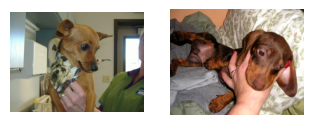

In [52]:
import random
plt.figure(figsize=(10,10))
temp = df[df['label'] == '1']['images'].sample(n=9).values
start = random.randint(0,len(temp))
files = temp[start:start+25]
for index,file in enumerate(files):
  plt.subplot(5,5,index+1)
  file = load_img(file)
  plt.imshow(file)
  plt.axis('off')

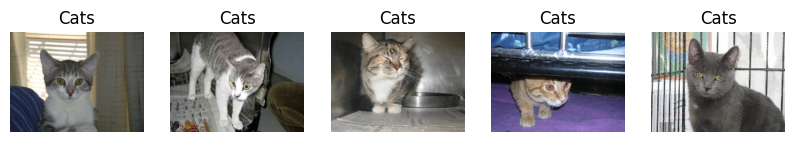

In [21]:
import random
plt.figure(figsize=(10,10))
temp = df[df['label'] == 0]['images'].sample(n=9).values
start = random.randint(0,len(temp))
files = temp[start:start+25]
for index,file in enumerate(files):
  plt.subplot(5,5,index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title('Cats')
  plt.axis('off')

<Axes: xlabel='label', ylabel='count'>

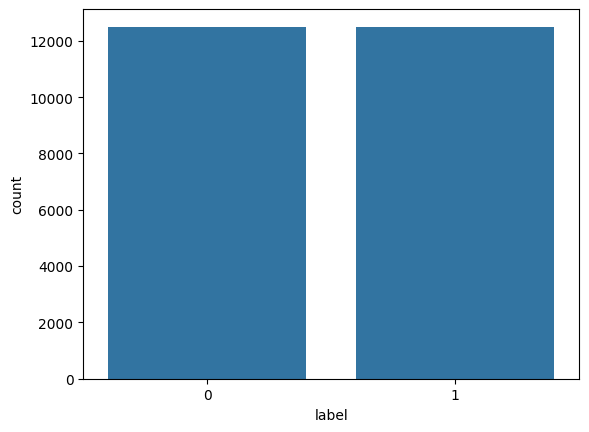

In [22]:
import seaborn as sns
sns.countplot(x= df['label'])

In [53]:
#input split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [54]:
train.head()

,images,label
23290,PetImages/Cat/10598.jpg,0
17785,PetImages/Cat/9821.jpg,0
1020,PetImages/Cat/9602.jpg,0
12648,PetImages/Cat/2758.jpg,0
1533,PetImages/Cat/1653.jpg,0


In [55]:
#creat datagenerate for the images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale=1./255, #normalization of images
    rotation_range = 40,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
val_generator = ImageDataGenerator(rescale=1./255)
train_iterator = train_generator.flow_from_dataframe(
    train,
    x_col = 'images',
    y_col = 'label',
    target_size = (128,128),
    class_mode = 'binary',
    batch_size = 512
)

val_iterator = val_generator.flow_from_dataframe(
    test,
    x_col = 'images',
    y_col = 'label',
    target_size = (128,128),
    class_mode = 'binary',
    batch_size = 512
)

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## Model Creation


In [56]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPool2D((2,2)),

    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [57]:
history = model.fit(train_iterator, epochs=10,
                    validation_data = val_iterator)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.5122 - loss: 0.8020 - val_accuracy: 0.6388 - val_loss: 0.6605
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.6021 - loss: 0.6594 - val_accuracy: 0.6126 - val_loss: 0.6466
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.6758 - loss: 0.6066 - val_accuracy: 0.7224 - val_loss: 0.5481
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.7083 - loss: 0.5618 - val_accuracy: 0.7526 - val_loss: 0.5105
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.7328 - loss: 0.5292 - val_accuracy: 0.7580 - val_loss: 0.5048
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.7488 - loss: 0.5087 - val_accuracy: 0.7680 - val_loss: 0.4858
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.7602 - loss: 0.4920 - val_accuracy: 0.7882 - val_loss: 0.4501
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.7804 - loss: 0.4677 - val_accuracy: 0.7900 - v

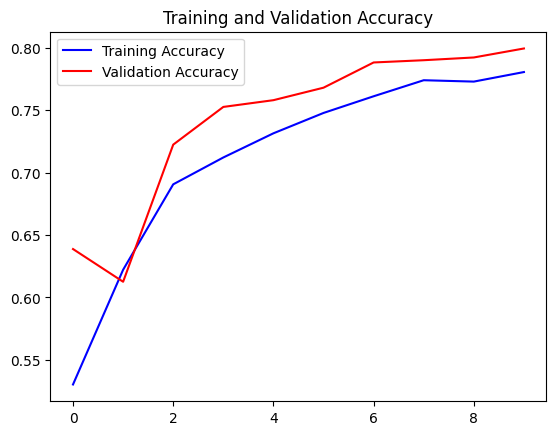

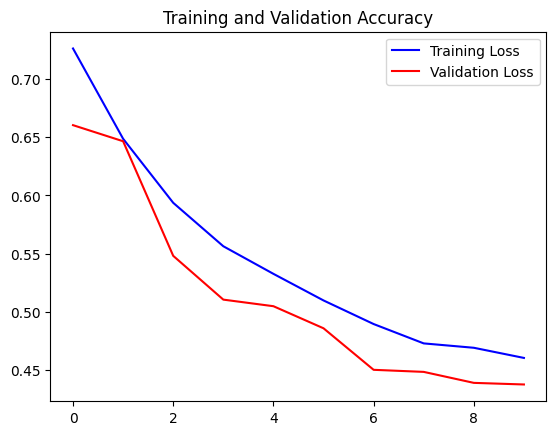

In [61]:
##visualization of results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs,acc,'b',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'r',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs,loss,'b',label = 'Training Loss')
plt.plot(epochs,val_loss,'r',label = 'Validation Loss')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [62]:
model.save("cat_dog_cnn.h5")